## <font color = "green"> Exposing <font color = "red">Fake Bills</font>: A Deep Dive into Counterfeit Currency Detection</font>

Counterfeit currency undermines trust in financial institutions and individuals, posing a grave threat to monetary system integrity. **Our project employs data analysis on a dataset of 1,500 bills, aiming to create a reliable system for distinguishing genuine from counterfeit money.** This initiative enhances fraud prevention, bolsters financial security, and fortifies the reliability of our monetary systems.

### Dataset Details

We'll use a dataset of 1500 rows & 7 columns, each row representing a bill with the following attributes:

- **is_genuine**: This column signifies the bill's authenticity.

- **diagonal**: Represents bill diagonal measurements(mm).

- **height_left**: Denotes the left side bill height(mm).

- **height_right**: Indicates right-side bill height(mm).

- **margin_low**: Specifies the bill's lower margin(mm).
 
- **margin_upper**: Defines the bill's upper margin(mm).

- **length**: Represents the bill's total length(mm).

These attributes are pivotal for our analysis as we explore and predict bill authenticity within the dataset.


## <font color = "blue"> Preliminary Exploratory Data Analysis</font>

In [2]:
# load libraries here
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### Reading in the Dataset
For this project, we will be using the [Fake Bills Dataset](https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills) from Kaggle.

In [3]:
bills_data <- read_delim("https://raw.githubusercontent.com/gordnzhou/DSCI-100-project/main/fake_bills.csv", 
                         delim = ";", show_col_types = FALSE )

head(bills_data)

is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,171.81,104.86,104.95,4.52,2.89,112.83
TRUE,171.46,103.36,103.66,3.77,2.99,113.09
TRUE,172.69,104.48,103.50,4.40,2.94,113.16
TRUE,171.36,103.91,103.94,3.62,3.01,113.51
TRUE,171.73,104.28,103.46,4.04,3.48,112.54
TRUE,172.17,103.74,104.08,4.42,2.95,112.81


### Data Wrangling

The data set is already tidy with well-formatted variable names. We'll make necessary adjustments for our analysis.

In [4]:
bills_data <- bills_data |>
    mutate(is_genuine = as_factor(is_genuine)) |>
    mutate(is_genuine = fct_recode(is_genuine, "Real" = "TRUE", "Fake" = "FALSE")) |>
    drop_na()
    
head(bills_data)

is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Real,171.81,104.86,104.95,4.52,2.89,112.83
Real,171.46,103.36,103.66,3.77,2.99,113.09
Real,172.69,104.48,103.50,4.40,2.94,113.16
Real,171.36,103.91,103.94,3.62,3.01,113.51
Real,171.73,104.28,103.46,4.04,3.48,112.54
Real,172.17,103.74,104.08,4.42,2.95,112.81


### Summary and Visualization

Splitting the data into training and testing subsets:

In [5]:
set.seed(99) # for reproducibility

bills_split <- initial_split(bills_data, prop = 0.75, strata = is_genuine)

bills_train <- training(bills_split)
bills_test <- testing(bills_split)

In the following analysis, we highlight 2 key data features.
- The mean value for each explanatory variable.
- Out of 1125 training data rows, 375 are `Fake`, and 750 are `Real`, indicating roughly double the data for real bills than fake bills.

In [6]:
bills_means <- bills_train |>
    select(diagonal:length) |>
    map_df(mean)

bills_count <- bills_train |>
    group_by(is_genuine) |>
    summarize(count = n())

bills_summary <- bills_train |>
    pivot_longer(cols = diagonal:length,
                 names_to = "column",
                 values_to = "value") |>
    group_by(column, is_genuine) |>
    summarize(mean = mean(value),
              sd = sd(value))   
        
bills_means
bills_count
bills_summary

`summarise()` has grouped output by 'column'. You can override using the
`.groups` argument.


diagonal,height_left,height_right,margin_low,margin_up,length
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
171.9582,104.0336,103.9237,4.488523,3.146545,112.6754


is_genuine,count
<fct>,<int>
Fake,369
Real,728


column,is_genuine,mean,sd
<chr>,<fct>,<dbl>,<dbl>
diagonal,Fake,171.885772,0.3010119
diagonal,Real,171.994986,0.3058899
height_left,Fake,104.187561,0.2218500
height_left,Real,103.955536,0.2951049
height_right,Fake,104.143144,0.2741229
height_right,Real,103.812541,0.2848625
length,Fake,111.633496,0.6211166
length,Real,113.203489,0.3497890
margin_low,Fake,5.212114,0.5605523


We plotted our data **using bill length (x-axis) and upper margin (y-axis), with points color-coded by authenticity (Fig 1.)**.

A cluster of fake bills appears in the upper-middle-left, while real bills cluster in the lower-right, indicating shorter bill length and larger upper margin as indicative of fake bills.

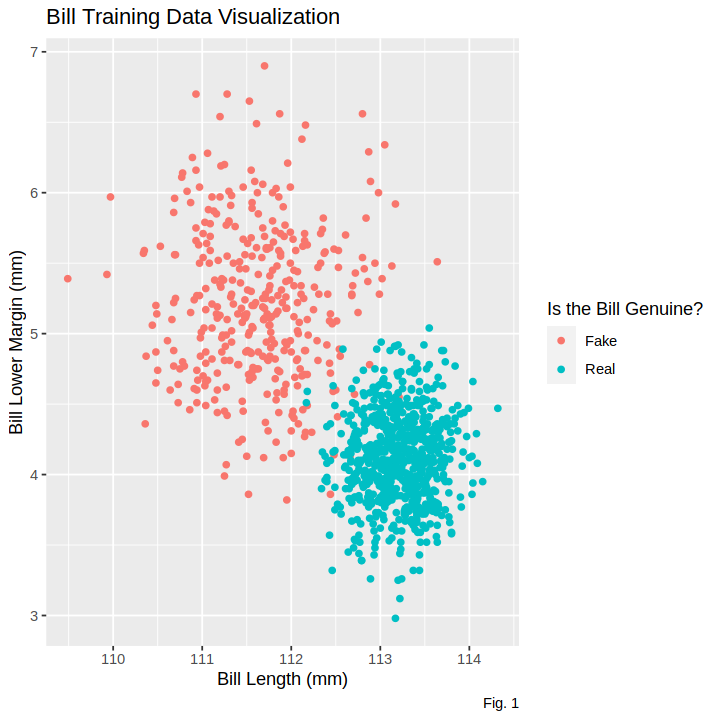

In [15]:
options(repr.plot.width = 6, repr.plot.height = 6)

bills_train_plot <- bills_train |>
    ggplot(aes(x = length, y = margin_low, colour = is_genuine)) +
        ggtitle("Bill Training Data Visualization") +
        geom_point() +
        labs(x = "Bill Length (mm)",
             y = "Bill Lower Margin (mm)",
             colour = "Is the Bill Genuine?",
             caption = "Fig. 1")

bills_train_plot

## <font color = "blue"> Methods</font>

For our explanatory variables, we will use `margin_low`, `margin_up`, `length`. Let's plot the distributions of real and fake bills for **each of our usable variables** and compare. 

We can see in Fig 2. that the measurements for fake and real bills have comparatively less **overlap** in our chosen variables (the bottom three), compared to the other three. This indicates that they have a stronger relationship with bill authenticity.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


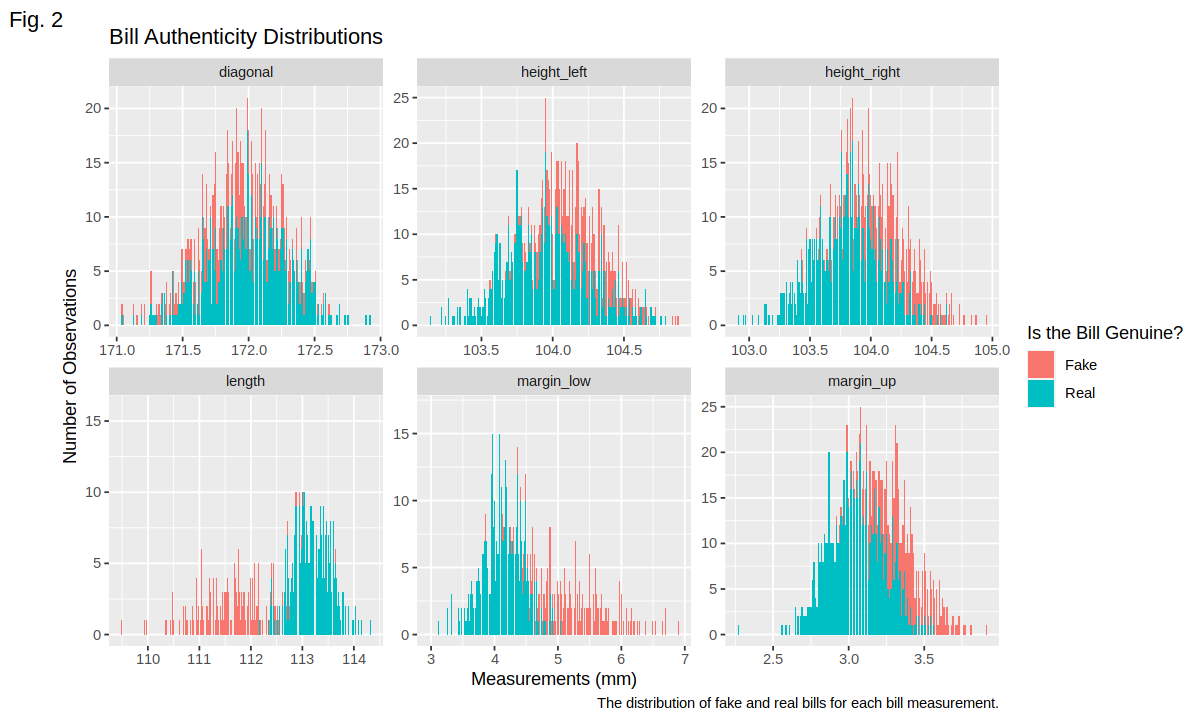

In [7]:
options(repr.plot.width = 10, repr.plot.height = 6)

# to separate variables for each distribution
bills_train_long <- bills_train |>
    pivot_longer(diagonal:length, names_to = "column")

bills_hist <- ggplot(bills_train_long, aes(x = value, fill = is_genuine)) +
    geom_histogram(stat = "count") +
    ggtitle("Bill Authenticity Distributions") +
    facet_wrap(column ~ ., scales = "free") +
    labs(x = "Measurements (mm)",
         y = "Number of Observations",
         fill = "Is the Bill Genuine?",
         tag = "Fig. 2",
         caption = "The distribution of fake and real bills for each bill measurement.")

bills_hist

In our analysis, we'll use the **K-Nearest Neighbors Classification** algorithm for bill authenticity. **Scaling** will ensure uniformity among variables. **To find the best K, we'll visualize Accuracy vs. K**. After model completion, we'll plot predictor variables and prediction areas to validate our results.

### <font color = "blue">Determining Best K</font>

neighbors,mean
<dbl>,<dbl>
2,0.9872394
3,0.9899750
4,0.9899750
5,0.9899750
6,0.9899750


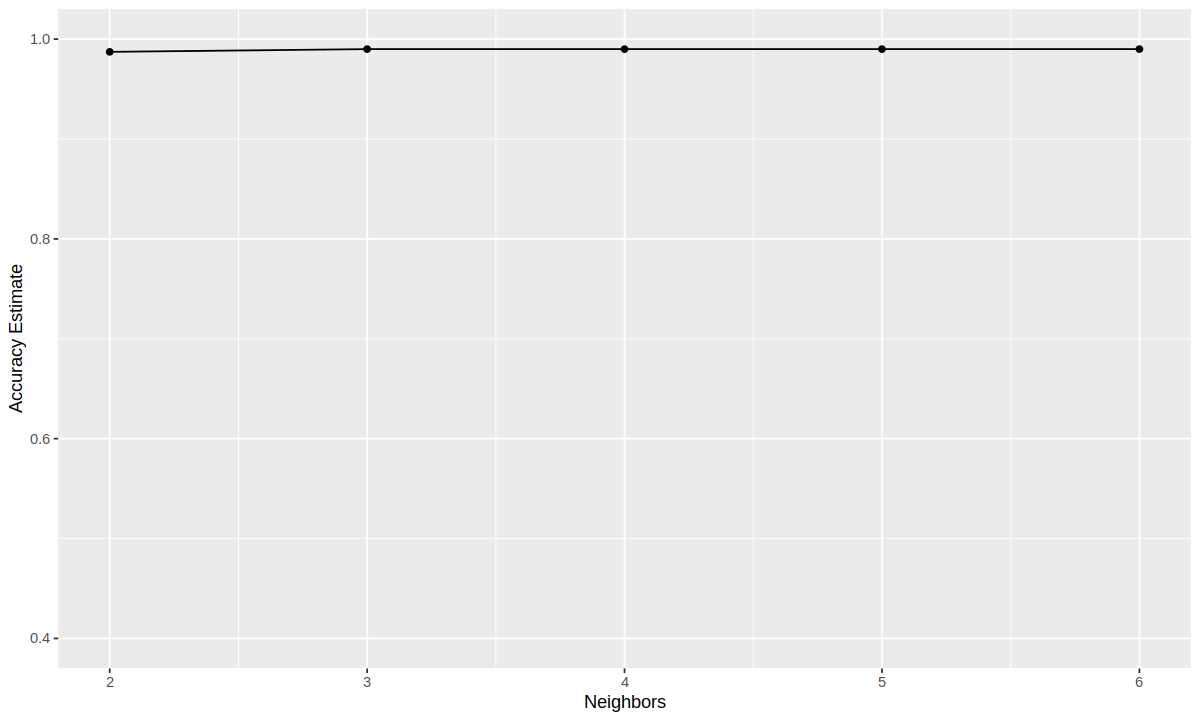

In [64]:
set.seed(123)

k_vals <- tibble(neighbors = c(2, 3, 4, 5, 6))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_recipe <- recipe(is_genuine ~ margin_low + margin_up + length, 
                     data = bills_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

train_vfold <- vfold_cv(bills_train, v = 5, strata = is_genuine)

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = train_vfold, grid = k_vals) |>
    collect_metrics(truth = is_genuine, estimate = .pred_class)

accuracies <- knn_fit |> 
      filter(.metric == "accuracy") |>
      select(neighbors, mean)

accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

cross_val_plot

We will use K = 5, but all values other than K = 1 would be valid as they all still produce very high accuracies.

In [66]:
best_k = 5

### <font color = "blue">Training and Evaluating our Model</font>

In [67]:
set.seed(456)

bills_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

bills_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(bills_spec) |>
    fit(data = bills_train)

bills_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.008204193
Best kernel: rectangular
Best k: 5

In [68]:
bills_predictions <- predict(bills_fit, bills_test) |>
    bind_cols(bills_test)

bills_metrics <- bills_predictions |>
  metrics(truth = is_genuine, estimate = .pred_class)

bills_conf_mat <-  bills_predictions |>
    conf_mat(truth = is_genuine, estimate = .pred_class)

bills_metrics
bills_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9890710
kap,binary,0.9755094


          Truth
Prediction Fake Real
      Fake  121    2
      Real    2  241

In [69]:
## TODO; add visualization of prediction areas

### <font color = "blue"> Expected Outcomes and Significance</font>
- Through our analysis, we'll identify key physical attributes that drive bill authenticity. Our findings will enhance the accuracy of differentiating between genuine and counterfeit bills, thus minimizing economic losses.  
- Our project contributes to strengthening financial transaction security and user confidence in currency authenticity, thus fostering more secure monetary transactions.

**Future Questions**
- How can these principles be applied to authenticate other global currencies?
- This project may stimulate advanced authentication methods like sensor technology and machine learning in ATMs and cash handling systems.

**In essence, our project works towards enhancing fraud prevention, financial security, and trust in currency, paving the way for future investigations in currency authentication.**